<a href="https://colab.research.google.com/github/mohammadsanaee/Course/blob/main/1-Experiments-with-Architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: Building the application for handwritten digits recognition

## 1. Pytorch Lightning

### 1.0 Introduction

**Pytorch Lightning** simplifies the programming process for training neural networks.

Usually, when we program the learning process, we operate with standard procedures, regardless of the problem that we will solve. These procedures go in a certain sequence, which we will call a pipeline.

For example, I can build a learning sequence like this:

```
1. Prepare and initialize the neural network, transfer it to
     required device (gpu, cpu, tpu, npu)

2. Prepare dataset

3. Initialize optimizer

4. Repeat n epochs:

     4.1 Perform training on the training dataset during the epoch:
         4.1.1 Take several examples (batch) from the dataset and preprocess them
               so that they can be passed through the network,
               transfer these examples to the one used in the learning process
               device (gpu, cpu, tpu, npu)

         4.1.2 Switch the neural network to learning mode (this is important if
               neural network there are modules that work differently in
               training and validation process, such as batch normalization)

         4.1.3 Run a batch through the neural network and get the network's response to
               teaching examples

         4.1.4 Compare the result of the neural network with the target values
               using the loss function

         4.1.5 Zero out previously calculated weight gradients

         4.1.6 Calculate new weight gradients using the inverse method
               error propagation (loss.backward())

         4.1.7 Make an optimizer step

         4.1.8 Calculate metrics on the current batch

         4.1.9 Update log, write learning status to file

         4.1.10 Switch the network to validation mode (just in case, so that
                statistics of batch normalizations were not accidentally spoiled somewhere)

         4.1.11 Check if we have reached a plateau. If yes, then slow down
                learning

     4.2 Perform validation on the validation dataset (same as
         training, but without optimization and without switching to training
         mode):

         4.2.1 ....
         4.2.2 ....

     4.3 Visualize several examples from the validation, training,
         test dataset:

         4.3.1 ....
         4.3.2 ....

     4.4 Save at the end of the epoch the weight of the model to a file, check if it is the best
         model, if the model is the best, then save the weights to a file with the best weights.

     4.5? ....

5 ? ....
```

The model training process may differ from task to task, but most of the components are standard.

If you write a very complex learning process with your hands, then you can make a random mistake (for example, very often programmers forget to switch between the training and test modes of the neural network, reset the gradients and make many other unpleasant errors). As a result, the neural network is trained incorrectly, and may not be trained at all. At the same time, it is extremely difficult to find such an error, since this is not a compilation error or division by 0: everything seems to work, but the result is not very good.

**Pytorch Lightning** allows you not to write a large enough amount of code, automating the transfer of network and data to the GPU or TPU, switching between neural network modes, and adding fairly simple logging. In addition, there are a lot of useful plugins for training neural networks using PyTorch Lightning. Therefore, to solve full-fledged problems of Machine Learning, it is desirable to use this library.


### 1.1 Library installation

First, let's install PyTorch Lightning using the pip terminal command. Terminal commands can be used in Jupyter Notebooks and Colabs. To run a terminal command, you must precede the command with an exclamation mark. For example, to view the contents of a folder, you can use the ```!ls``` command.

In [1]:
!pip install -q pytorch-lightning

# the -q flag allows you to significantly reduce the output when installing a package

### 1.2 Imorting the modules

In this practice, we will use several libraries. First is ```Pytorch Lightning```. In addition, we need ```Pytorch``` itself: we will use it to define neural networks.

In [2]:
!pip install pytorch-lightning==1.9.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pytorch_lightning as pl
import torch

### 1.3 Reproducible training

In order to do A-B tests and gradually improve the learning process of the neural network, you need to make sure that the learning result is reproducible from run to run. Since pseudo-random numbers are often used in training neural networks, it is necessary that random number generators produce the same sequences from run to run. In addition, you need to switch CUDA to deterministic mode. This requirement reduces the speed of program execution, but the results of calculations become reproducible.

In [4]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pl.seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

## 2. Preparing data, dataset class and data loaders

### 2.0 Introduction

In order to be able to pull out a training example by index and know how many training examples are contained in the dataset, a dataset is usually written. In this practice, we will use standard datasets, so we just need to initialize the standard objects of the **MNIST** class, which are implemented in the torchvision standard library.

Below we initialize two datasets: training and test.

In real life, for this it is necessary to implement some class that stores the data index (that is, information about where and how the data is stored), and also returns one training example upon request.

In order to make a dataset class, you need to make a class with the following interface:



```python
classDataset:
     def __init__(self):
         # Constructor code where it usually happens
         # collecting an index about the dataset: paths to files,
         # about how the data is related and
         # etc.
         #
         # Here it is also worth setting augmentations,
         # which will be used in the dataset.

     def __len__(self):
         # This method is required in order to be
         # it is possible to get the number of elements in
         # dataset using the len() method:
         #
         #len(dataset)
         #
         # This method is used by standard
         # data loader classes in PyTorch.
         #
         # The method must return a number.

     def __getitem__(self, index):
         # This method loads one
         # example from the dataset. Here is an image and
         # the markup is read from disk and then normally
         # are augmented.
         #
         # The method must return either a tuple,
         # either a list or a dictionary. Preferably from
         # torch tensors.
```

### 2.1 Dataset initialization

In this notebook, we will not write our own datasets, but will use those that are available in the `torchvision` auxiliary library. We will be interested in the `MNIST` dataset.

1. Examine the interface of the `torchvision.datasets.MNIST` class. See what parameters this dataset can influence.

2. Initialize training and test datasets (`torchvision.datasets.MNIST`).

3. In the constructor, use the following parameters:
     * augmentations from `torchvision.transforms`:
         * `transforms.ToTensor()`
         * `transforms.Normalize((0.1307,), (0.3081,))`

     * `root` -- whatever you like
     * analyze and set the rest of the arguments as you think is more correct. Do not forget that shuffling the dataset makes sense for the training set.

#### Hint: Documentation

To view the documentation of a function (or class constructor):

1. Type the name of the function in the same way as it will be used in the code, but without brackets.
2. Place a question mark `?` after the function name and
3. execute the cell.

A "Help" window will appear in the right window, where the documentation will be displayed.

#### Hint: dataset arguments

* example path: `root='MNIST/train.pt'` for train and `root='MNIST/test.pt'` for test
* you need to set the `download=True` argument in order for the data to be downloaded from the server
* in order for the data to be transformed into `torch.Tensor`, you must set the `transforms=transforms.ToTensor()` argument. With the same argument, you can configure various basic augmentations available in `torchvision.transforms`. In practice, these augmentations are not recommended. We will use `albumentations` in the future.

#### Code

In [5]:
from torchvision.transforms.transforms import Resize

import torchvision
from torchvision import transforms

## YOUR CODE HERE
from torchvision.datasets import CIFAR10

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensors
])

# Define the testing transforms
test_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensors
])

# Create the CIFAR10 datasets with the respective transforms
train_dataset = torchvision.datasets.CIFAR10('VOC', download=True, transform=train_transforms, train=True)
test_dataset = torchvision.datasets.CIFAR10('VOC', download=True, transform=test_transforms, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
#@title Unit Test

# Checking the datasets classes
assert(isinstance(train_dataset, torchvision.datasets.CIFAR10))
assert(isinstance(test_dataset, torchvision.datasets.CIFAR10))

# Checking volumes of the datasets
assert(len(train_dataset) == 50000)
assert(len(test_dataset) == 10000)

# Checking outputs of the datasets
assert(isinstance(train_dataset[0][0], torch.Tensor))
assert(isinstance(train_dataset[0][1], int))

# Checking dimentionalities
assert(train_dataset[0][0].shape == torch.Size((3, 32, 32)))
assert(train_dataset[0][1] == 6)

print('OK')

OK


#### Checking the dataset

It is very important to check that the dataset works as it should. To do this, it is worth visualizing the picture if we are working with images, looking at the text if we are dealing with texts, or listening to the audio track if sound is being analyzed.

You need to check that the image is displayed correctly, and also that the label, if any, matches the image.

You should also pay attention to data sizes (the `.shape` method). Most of the errors can be found by analyzing only the size of the data.

It's worth looking at some data.

Number of examples in training and test dataset:
50000 10000
Image size. NOTE that number of channels comes first:
torch.Size([3, 32, 32])
Image class and class name:
6 frog


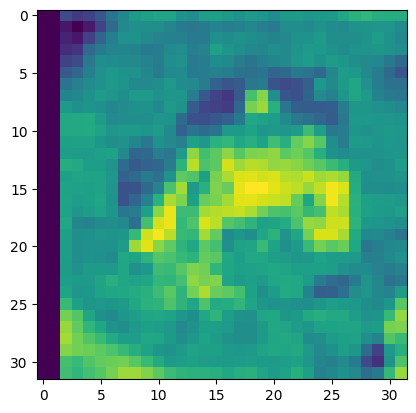

In [7]:
import matplotlib.pyplot as plt

print('Number of examples in training and test dataset:')
print(len(train_dataset), len(test_dataset))
print('Image size. NOTE that number of channels comes first:')
print(train_dataset[0][0].shape)
plt.imshow(train_dataset[0][0][0]) # draw the image
print('Image class and class name:')
print(train_dataset[0][1], train_dataset.classes[train_dataset[0][1]])

### 2.2 Creating data loaders

The datasets are defined. In order to automatically extract from datasets
batches (small bundles of data that are ready to be passed to the input of the neural network), there is a special class in pytorch: DataLoader (loader). It can be
flexible enough to configure:

* select the batch size to be
pulled out of the DataLoader,

* choose how many parallel processes to use for
batch processing (this significantly reduces the time for data processing, including
when augmentations are used).

* shuffle data
(this is useful for training data: then the batches that enter the network
will vary).

* discard last batch on load

Discarding the last batch in the training dataset is very important,
since it can be small, the statistics that are calculated from it can be
unrepresentative. As a result, batch normalizations will be corrupted.
To avoid this, the ```drop_last``` parameter is provided.

#### Exercise

Configure data loaders. Set: batch size 32, number of processing threads (workers) 8.

Set the training data to random shuffle and discard the last batch.

##### Hint: loader arguments

For the training dataset, set:
* `batch_size` equal to `32`
* `num_workers` to `8`
* `shuffle` to `True`
* `drop_last` to `True`

For a test dataset, set:
* `batch_size` equal to `32`
* `num_workers` to `8`
* `shuffle` to `False`

#### Code

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset,batch_size = 32, shuffle = True, num_workers = 8, drop_last = True) #YOUR CODE HERE
test_loader  = DataLoader(test_dataset,batch_size = 32, shuffle = False, num_workers = 8) #YOUR CODE HERE

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 3. Defining the error function and metrics

### 3.1 Loss functions

For any task, it is necessary to define a loss function, with the help of which the model will be trained. The loss function can be set by hand, or you can use a ready-made one.

In this practice, we will use the already implemented loss function: ```torch.nn.CrossEntropyLoss```.

We will do this in the first place because this loss function combines `torch.nn.SoftMax` and the cross-entropy `torch.nn.NLLloss` itself, which prevents numerical instability when calculating the loss. It is rare, but in some cases it can spoil the learning process.

In case you need to use some custom loss function, you can implement the `loss` function, which will return a `torch.Tensor` consisting of a single number. This is important so that you can later use `backward` for gradient calculations.

#### Exercise

Initialize the loss ```torch.nn.CrossEntropyLoss```.

#### Code

In [9]:
loss = torch.nn.CrossEntropyLoss() # YOUR CODE HERE

In [10]:
#@title Unit Test
import torch

for index in range(1000):
    x = torch.randn([10, 10])
    y = torch.randint(0, 10, size=[10])

    assert((loss(x, y) - torch.nn.functional.cross_entropy(x, y)).abs().mean() < 1.0e-8)

print('OK')

OK


### 3.2 Metrics

For a normal person, loss is not informative. In order for us to understand how well or poorly the model actually works, we need to decide on a metric. We will use the "accuracy" metric.

To calculate metrics, there is a library [torchmetrics] (https://github.com/PyTorchLightning/metrics). We will use this library in our projects.

In order to implement a metric for PyTorch Lightning, you need to implement a class inherited from `trochmetrics.Metrics`, in which to implement three methods:

* ```__init__(self)``` -- constructor. In the constructor, you must initialize the parent class with ```super().__init__()```. It is also necessary to initialize all auxiliary variables here (in our case, the ```correct``` fields, the number of correctly guessed objects, and the ```total``` field, the total number of classified objects). Variables must be declared in a special way: using the ```self.add_state``` method. For example, to define a field ```correct```, you need to write in the constructor: ```self.add_state("correct", default=torch.tensor(0.0), dist_reduce_fx="sum")```. The last parameter is needed for multi-threaded learning.

* ```update(self, preds, targets)``` -- update when new neural network results are received. The input is tensors with the results of the network and target variables (batches). Usually this method is to update auxiliary variables. In our case, we need to add the number of guessed data to ```self.correct``` and the total number of objects in the batch to ```self.total```, which were declared in the constructor. Shouldn't return anything.

* ```compute(self)``` is a method that calculates the metric value from auxiliary variables. In our case -- divides ```self.correct``` by ```self.total```.

In [11]:
import torchmetrics

class Accuracy(torchmetrics.Metric):
    def __init__(self):
      super().__init__()
      self.add_state("correct", default=torch.tensor(0.0), dist_reduce_fx="sum")
      self.add_state("total", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds, target):
        self.correct += torch.sum(preds.argmax(dim=1)==target).item()
        self.total += target.numel()

    def compute(self):
        return self.correct/self.total

In [12]:
#@title Unit test

correct = 0
all = 0

acc = Accuracy()

for index in range(1000):
    preds = torch.randn([1000, 100])
    targs = torch.randint(0, 100, size=[1000])
    acc.update(preds, targs)

    correct += (preds.argmax(dim=1) == targs).float().sum()
    all += targs.numel()

    assert((acc.compute() - correct / all).abs().mean() < 1.0e-8)

# acc.update(preds, targs)
# assert(acc.compute() == 1.0 / 3.0)

print('OK')

OK


## 4. Building the network and getting ready to train it

### 4.1. Architecture preparation

#### Exercise

We will make a simple two-layer fully connected network and train it. This network will have the following modules:

```
*BatchNorm1d
Linear 28 * 28 -> n_hidden
activation: ReLU, LeakyReLU, ELU, Tanh
*BatchNorm1d
Linear n_hidden -> 10
```

In order to make a neural network architecture, it is necessary to define a class inherited from `torch.Module`, in which the following methods must be defined:

* ```__init__(self)``` -- constructor to define the neural network modules to be used (same as in PyTorch). In addition, here it is necessary to initialize the classes of metrics and loss functions. Before declaring modules, you must call ```super().__init__()``` to initialize the parent class that provides the main functionality.

* ```forward(self, input)``` -- pass through the network forward. Here you need to make predictions from ```input``` using modules defined in the constructor (nothing special here either, just like in PyTorch).

#### Code

In [13]:
# import torch.nn as nn
# class Network(torch.nn.Module):

#     def __init__(self,n_hidden):
#         super().__init__()
#          # YOUR CODE HERE
#         # n_hidden = 64
#         self.batchnorm1 = nn.BatchNorm1d(28*28)
#         self.linear1 = nn.Linear(28*28,n_hidden)
#         self.activation = nn.LeakyReLU()
#         self.batchnorm2 = nn.BatchNorm1d(n_hidden)
#         self.linear2 = nn.Linear(n_hidden,10)

#     def forward(self, x):
#          # YOUR CODE HERE
#          x = x.view(x.size(0), -1)
#          x = self.batchnorm1(x)
#          x = self.linear1(x)
#          x = self.activation(x)
#          x = self.batchnorm2(x)
#          x = self.linear2(x)
#          return x




In [14]:
# #@title Unit test

# x = torch.zeros(10, 1, 28, 28)
# net = Network(64)
# res = net.forward(x)

# print('OK')

### 4.2. Preparing the Pytorch Lightning Module

In order to prepare the network for training on PyTorch Lightning, you need to make a class inherited from ```pl.LightningModule```.

In this class, you need to define:
* As in PyTorch:
     * `__init__(self)`
     * `forward(self, x)`

In our case, for convenience, it makes sense to initialize the `self.model` Pytorch field in `__init__` with the model specified earlier, and use the same method from `self.model` in the forward method.

* Minimal kit for PyTorch Lightning:
   * ```training_step(self, batch, batch_idx)``` -- here, from network predictions made using the forward method, loss functions and metrics are calculated and logged. In order to log some value, you need to do: ```self.log('name_of_value/train', value, on_epoch=True)``` The function must return the value of the loss.
   * ```configure_optimizers(self)```. This is where the optimizers must be defined. For example, I can define an optimizer like this: ```optim = torch.optim.Adam(self.parameters(), lr=1.0e-3)```. It is also convenient to define schedulers for optimizers here. For example, a scheduler could be defined like this: ```sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='max', factor=0.3, verbose=True)```. The function must return a list of optimizers or a single optimizer (if there is only one optimizer).

* In order to be able to calculate the metrics for validation, we will also implement
   * ```validation_step(self, batch, batch_idx)``` -- same as training_step, only for validation set. This function may not return anything.

#### Exercise

Populate the Pytorch Lightning class as described above

#### VGG Network

In [15]:
class ConvNormAct(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.module = torch.nn.Sequential(
            torch.nn.Conv2d(*args, **kwargs),
            torch.nn.BatchNorm2d(args[1]),
            torch.nn.LeakyReLU()
        )

    def forward(self, input):
        return self.module.forward(input)


class VGG(torch.nn.Module):
    def __init__(self, act=torch.nn.LeakyReLU):
        super().__init__()
        self.conv_modules = torch.nn.Sequential(
            ConvNormAct(3, 32, 3, padding=1), #  Stem: ConvNormAct 3 -> 32
            ## block 1
            ConvNormAct(32, 32, 3, padding=1),
            ConvNormAct(32, 64, 3, padding=1),
            torch.nn.MaxPool2d(2),
            ## block 2
            ConvNormAct(64, 64, 3, padding=1),
            ConvNormAct(64, 128, 3, padding=1),
            torch.nn.MaxPool2d(2),
            ## block 3
            ConvNormAct(128, 128, 3, padding=1),
            ConvNormAct(128, 256, 3, padding=1),
            torch.nn.MaxPool2d(2),
            ## block 4
            ConvNormAct(256, 256, 3, padding=1),
            ConvNormAct(256, 256, 3, padding=1),
            torch.nn.MaxPool2d(2)

        )
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d([1, 1])
        self.classifier = torch.nn.Linear(256, 10)

    def forward(self, input):
        res = input
        res = self.conv_modules(res)
        res = res.mean(dim=[-1, -2])
        res = self.classifier(res)
        return res

##### RESNET

In [16]:
class ResBlock(torch.nn.Module):
    def __init__(self, module, bypass=torch.nn.Identity()):
        super().__init__()
        self.module = module
        self.bypass = bypass

    def forward(self, input):
        return self.module(input) + self.bypass(input)

class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = torch.nn.Sequential(
            ConvNormAct(3, 32, 3, padding=1), # stem

            # block 1 32x32
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(32, 8, 3, padding=1),
                    ConvNormAct(8, 32, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(32, 8, 3, padding=1),
                    ConvNormAct(8, 32, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(32, 8, 3, padding=1),
                    ConvNormAct(8, 32, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(32, 8, 3, padding=1),
                    ConvNormAct(8, 32, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(32, 16, 3, stride=2, padding=1),
                    ConvNormAct(16, 64, 3, padding=1)),
                    bypass=torch.nn.Conv2d(32, 64, 1, stride=2)),

            # block 2
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(64, 16, 3, padding=1),
                    ConvNormAct(16, 64, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(64, 16, 3, padding=1),
                    ConvNormAct(16, 64, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(64, 16, 3, padding=1),
                    ConvNormAct(16, 64, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(64, 16, 3, padding=1),
                    ConvNormAct(16, 64, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(64, 32, 3, stride=2, padding=1),
                    ConvNormAct(32, 128, 3, padding=1)),
                    bypass=torch.nn.Conv2d(64, 128, 1, stride=2)),
            # block 3
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(128, 32, 3, padding=1),
                    ConvNormAct(32, 128, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(128, 32, 3, padding=1),
                    ConvNormAct(32, 128, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(128, 32, 3, padding=1),
                    ConvNormAct(32, 128, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(128, 32, 3, padding=1),
                    ConvNormAct(32, 128, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(128, 32, 3, stride=2, padding=1),
                    ConvNormAct(32, 256, 3, padding=1)),
                    bypass=torch.nn.Conv2d(128, 256, 1, stride=2)),
            # block 4
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(256, 64, 3, padding=1),
                    ConvNormAct(64, 256, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(256, 64, 3, padding=1),
                    ConvNormAct(64, 256, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(256, 64, 3, padding=1),
                    ConvNormAct(64, 256, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(256, 64, 3, padding=1),
                    ConvNormAct(64, 256, 3, padding=1))),
            ResBlock(
                torch.nn.Sequential(
                    ConvNormAct(256, 64, 3, padding=1, stride=2),
                    ConvNormAct(64, 256, 3, padding=1)),
                    bypass=torch.nn.Conv2d(256, 256, 1, stride=2)),
        )
        self.classifier = torch.nn.Linear(256, 10)

    def forward(self, input):
        res = input
        res = self.conv_net(res)
        res = res.mean(dim=[-1, -2])
        res = self.classifier(res)
        return res

GRU CONV NET

In [17]:
class GRUx(torch.nn.Module):
  def __init__(self,in_ch,out_ch):
    super().__init__()
    self.module = torch.nn.GRU(in_ch,out_ch,bidirectional = True)

  def forward(self,input):
    batch_size = input.shape[0]
    IMG = input
    IMG = IMG.permute([2, 1, 0, 3])
    IMG = IMG.reshape([IMG.shape[0], IMG.shape[1], -1])
    IMG = IMG.permute([0, 2, 1])
    res,memo = self.module(IMG)
    res = res.permute([0,2,1])
    res = res.reshape([res.shape[0], res.shape[1],batch_size,-1])
    res = res.permute([2,1,0,3])
    return res

class GRUy(torch.nn.Module):
  def __init__(self,in_ch,out_ch):
    super().__init__()
    self.module = torch.nn.GRU(in_ch,out_ch,bidirectional = True)

  def forward(self,input):
    batch_size = input.shape[0]
    IMG = input
    IMG = IMG.permute([3, 1, 0, 2])
    IMG = IMG.reshape([IMG.shape[0], IMG.shape[1], -1])
    IMG = IMG.permute([0, 2, 1])
    res,memo = self.module(IMG)
    res = res.permute([0,2,1])
    res = res.reshape([res.shape[0], res.shape[1],batch_size,-1])
    res = res.permute([2,1,0,3])
    return res

class GRU_conv(torch.nn.Module):
  def __init__(self,in_ch,out_ch,m_ch):
    super().__init__()
    self.GRUX = GRUx(in_ch,m_ch)
    self.GRUY = GRUy(in_ch,m_ch)
    self.out_conv = torch.nn.Conv2d(4*m_ch,out_ch,1)

  def forward(self,input):
    res = input
    x_res = self.GRUX.forward(res)
    y_res = self.GRUY.forward(res)
    res = torch.cat([x_res, y_res], dim=1) # problem
    res = self.out_conv(res)
    return res

class GRU_VGG(torch.nn.Module):
  def __init__(self,activation = torch.nn.LeakyReLU):
    super().__init__()
    self.conv_module = torch.nn.Sequential(
        ConvNormAct(3, 32, 3, padding=1),
        #Block1
        GRU_conv(32,32,32),
        GRU_conv(32,64,64),
        torch.nn.MaxPool2d(2),
        #Block2
        GRU_conv(64,64,64),
        GRU_conv(64,128,128),
        torch.nn.MaxPool2d(2),
        #Block3
        GRU_conv(128,128,128),
        GRU_conv(128,256,256),
        torch.nn.MaxPool2d(2),
        #Blcok4
        GRU_conv(256,256,256),
        GRU_conv(256,256,256),

    )
    self.global_avg_pool = torch.nn.AdaptiveAvgPool2d([1, 1])
    self.classifier = torch.nn.Linear(256, 10)
  def forward(self,input):
    res = input
    res = self.conv_module(res)
    res = res.mean(dim = [-1,-2])
    res = self.classifier(res)
    return res

In [18]:
#@title Unit test

x = torch.zeros(10, 3, 32, 32)
net = VGG()
res = net.forward(x)

print('OK')

OK


In [19]:
#@title Unit test

x = torch.zeros(10, 3, 32, 32)
net = ResNet()
res = net.forward(x)

print('OK')

OK


In [20]:
#@title Unit test

x = torch.zeros(10, 3, 32, 32)
net = GRU_VGG()
res = net.forward(x)

print('OK')

OK


In [21]:
class PLModel(pl.LightningModule):
    def __init__(self, model):

      super().__init__()
       # YOUR CODE HERE
      self.model = model


    def forward(self, input):
      return self.model(input) # YOUR CODE HERE


    def training_step(self, batch, batch_idx):
       # YOUR CODE HERE
      x,y = batch
      pred = self.model(x)
      loss_value = loss(pred,y)
      self.log('train_loss', loss_value,on_epoch=True)
      return loss_value

    def validation_step(self, batch, batch_idx):
      # YOUR CODE HERE
      x,y = batch
      pred = self.model(x)
      # acc.update(preds, y)
      # val_accuracy = acc.compute()
      val_accuracy=acc(pred,y)
      self.log('val_accuracy', val_accuracy, on_epoch=True)
      return val_accuracy


    def configure_optimizers(self):
       # YOUR CODE HERE
      optimizer = torch.optim.Adam(self.parameters(), lr=1.0e-3)
      # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.3, verbose=True)
      return [optimizer]


## 5. Training

### 5.1. TensorBoard

**Tensorboard** is the standard way to track learning progress. In TensorBoard, you can plot metrics and loss functions, draw pictures and track how they change over time. PyTorch Lightning automatically writes logs to TensorBoard.

### 5.2. Start training

By default, Pytorch Lightning uses not the most convenient and informative progress bar. Therefore, below we have made a more interesting progress bar, which allows you to track the learning process more conveniently and does not load the browser.

In [22]:
import datetime
print(str(datetime.time()))

00:00:00


In [24]:
#@title Custom ProgressBar Code (Code is complex and irrelevant to the task)

import sys
import math
import time
import datetime
import copy
import numpy
import os

try:
    from IPython.display import display, update_display
except:
    pass

def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        module = get_ipython().__class__.__module__
        if module == "google.colab._shell":
            return True
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False

def nlines(text):
    return text.count('\n') + 1

status = {
    'Info': '5/10 [######9     ] 59%',
    'Time/D': 0.9999999999999999999999,
    'Time/B': 0.1238476123864126345187245,
    'Time/AvgD': 0.812341348176234987162349817643,
    'Time/AvgB': 0.8561283745187634581726345,
    'Loss/L1': 112398746192834619827364,
    'Loss/L2': 19234618623.0,
    'Loss/L2.5': 1,
    'Loss/L3': 0.8126347152,
    'Loss/L4': 10,
    'Loss/L5': numpy.inf,
    'Metrics/One': 0.888888,
    'Metrics/Two': 123987.0,
    'Metrics/Three': 1.0
}


def textcolor(style=None, color=None):
    if color is None:
        color = 0
    else:
        color_code = 30 + color
    if style is None:
        style_code = 0
    else:
        style_code = style
    return '\033[' + str(style_code) + ';' + str(color_code) + 'm', '\033[' + str(0) + ';' + str(0) + 'm'


def format_status(inp):
    if isinstance(inp, (dict)):
        for key in inp:
            inp[key] = format_status(inp[key])

    if isinstance(inp, (list, tuple)):
        for index in range(len(inp)):
            inp[index] = format_status(inp[index])

    if isinstance(inp, torch.Tensor):
        inp = inp.detach().cpu().numpy()

    if isinstance(inp, int):
        if abs(inp) > 10 ** 6:
            return '{:.3e}'.format(inp)
        else:
            return '{:d}'.format(inp)

    if isinstance(inp, float):
        if abs(inp) > 10 ** 6:
            return '{:.3e}'.format(inp)
        elif abs(inp) < 10 ** -6:
            return '{:.3e}'.format(inp)
        else:
            return '{:.6f}'.format(inp)

    return inp


def colorize_string(string, colors, padding=0):
    indice = []
    for color in colors:
        indice.append(colors[0])

    substrings = []
    last_index = 0
    for color in colors:
        index = color[0] + padding
        substrings.append(string[last_index:index])
        substrings.append(color[1])
        last_index = index
    substrings.append(string[last_index:])
    return ''.join(substrings)


def view_status(inp, display_len=80):
    separator = ' | '
    strings = ['']
    colors = [[]]
    color_index = 0

    maxlen = 0
    for key in inp:
        maxlen = max(len(str(key)), maxlen)

    for key in inp:

        start, end = textcolor(style=1, color=color_index + 1)
        colors[-1].append((len(strings[-1]), start))
        strings[-1] += ('{:>' + str(maxlen) + 's} ').format(key)
        colors[-1].append((len(strings[-1]), end))

        if isinstance(inp[key], (list, tuple)):
            strings[-1] += separator.join(inp[key])

        elif isinstance(inp[key], dict):
            pos = len(strings[-1])
            subres = []

            for subkey in inp[key]:
                start, end = textcolor(style=3, color=color_index + 1)
                colors[-1].append((pos, start))
                colors[-1].append((pos + len(subkey), end))
                subres.append(subkey + ': ' + str(inp[key][subkey]))
                pos = pos + len(subkey) + len(': ') + len(str(inp[key][subkey])) + len(separator)
            strings[-1] += separator.join(subres)

        else:
            strings[-1] += str(inp[key])

        strings.append('')
        colors.append([])

        color_index += 1
        color_index %= 6

    new_strings = []
    new_colors = []
    new_strings.append('=' * display_len)
    for index in range(len(strings)):
        string = strings[index]
        str_colors = colors[index]
        position = 0
        color_index = 0
        padding = 0
        while len(string) > 0:
            splitter_location = -1

            if len(string) > display_len:
                splitter_location = string[:display_len].rfind(' | ')

            split_colors = []

            if splitter_location > 0:
                string_end = splitter_location
            else:
                string_end = min(display_len, len(string))
            while color_index < len(colors[index]) and colors[index][color_index][0] - position < string_end - padding:
                split_colors.append(list(colors[index][color_index]))
                split_colors[-1][0] -= position
                color_index += 1

            if len(string) < display_len:
                to_print = string
                to_print = to_print + ' ' * (display_len - len(to_print))
                new_strings.append(colorize_string(to_print, split_colors, padding=padding))
                break

            elif splitter_location > 0:
                to_print = string[:splitter_location]
                to_print = to_print + ' ' * (display_len - len(to_print))
                new_strings.append(colorize_string(to_print, split_colors, padding=padding))
                split_colors = []
                string = ' ' * (maxlen + 1) + string[splitter_location + 3:]
                position += splitter_location + 3 - padding
                padding = maxlen + 1

            else:
                to_print = string[:string_end]
                to_print = to_print + ' ' * (display_len - len(to_print))
                new_strings.append(colorize_string(to_print, split_colors, padding=padding))
                split_colors = []
                string = ' ' * (maxlen + 1) + string[string_end:]
                position += string_end - padding
                padding = maxlen + 1

    new_strings.append('=' * display_len)
    return '\n'.join(new_strings)


def dict_to_multidict(status):
    decomposed_status = {}
    for key in list(status.keys()):
        key_parts = key.split('/')
        if len(key_parts) > 2:
            continue

        if len(key_parts) > 1:
            superkey = key_parts[0]
            subkey = '/'.join(key_parts[1:])

            if superkey not in decomposed_status:
                decomposed_status[superkey] = {}

            decomposed_status[superkey][subkey] = status[key]
        else:
            decomposed_status[key] = status[key]

    return decomposed_status


def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        module = get_ipython().__class__.__module__
        if module == "google.colab._shell":
            return True
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False


def nlines(text):
    return text.count('\n') + 1


def get_width():
    try:
        return os.get_terminal_size()[0] - 1
    except :
        return 100



class StageProgressBar:
    def __init__(self, width_function=None, display_id='ep{}'.format(0), is_ipython=None):
        self.width_function = width_function


        self.last_vals = None
        self.finalized = False
        self.started = False

        self.is_ipython = isnotebook() if is_ipython is None else is_ipython
        self.display_id = display_id

    def __str__(self):
        status = format_status(self.last_vals)
        to_view = view_status(dict_to_multidict(status), display_len=self.width)
        return to_view

    def display(self, content):
        if not self.is_ipython:
            print(content, end='')
            print('\033[' + str(nlines(content)) + 'A')
        else:
            # print(self.display_id)
            update_display({'text/plain': content}, display_id=self.display_id, raw=True)

    def __del__(self):
        self.finalize()

    def update(self, vals):
        if self.finalized:
            return

        self.width = self.width_function()
        self.last_vals = vals
        cur_info = str(self)

        if not self.started:
            self.started = True
            if self.is_ipython:
                print(self.display_id, '<- display_id')
                display({'text/plain': ''}, display_id=self.display_id, raw=True)

        self.display(cur_info)

    def finalize(self):
        if (not self.finalized) and (not self.is_ipython):
            print(str(self))

def progress_str(width, state):
    progress = width * state
    filled = int(math.floor(progress))

    if filled < width:
        remnant = str(int(math.floor((progress - filled) * 10.0)))
        return '[' + '='* filled + remnant + ' ' * (width - filled - 1) + ']'
    else:
        return '[' + '=' * width + ']'

class TimeEstimator:
    def __init__(self, eta_threshold=0.001):
        self.eta_threshold = eta_threshold
        self.reset()

    def reset(self):
        self.start_time = time.time()
        self.cur_state = 0
        self.est_finish_time = None
        return self

    def update(self, cur_state):
        self.cur_state = cur_state
        if self.cur_state >= self.eta_threshold:
            self.est_finish_time = self.start_time + (time.time() - self.start_time) / self.cur_state

    def __str__(self):
        elapsed = str(datetime.timedelta(seconds=int(time.time() - self.start_time)))
        if self.est_finish_time is not None:
            eta = str(datetime.timedelta(seconds=int(self.est_finish_time - time.time())))
        else:
            eta = '?'

        return f'[{elapsed}>{eta}]'


class LiteProgressBar(pl.callbacks.ProgressBarBase):
    def __init__(self):
        super().__init__()
        self.last_epoch = 0
        self.pbar = StageProgressBar(width_function=get_width, display_id='ep{}'.format(0))
        self.timer = TimeEstimator()
        self.display_counter = 0

    def disable(self):
        self.enable = False

    def on_train_epoch_start(self, *args, **kwargs):
        super().on_train_epoch_start(*args, **kwargs)
        self.timer.reset()
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'train'
        log['Info/Progress'] = progress_str(15, 0)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)
        self.pbar.update(trainer.logged_metrics)

    def on_train_epoch_end(self, *args, **kwargs):
        super().on_train_epoch_end(*args, **kwargs)
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'train'
        log['Info/Progress'] = progress_str(15, 1.0)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)
        self.pbar.update(trainer.logged_metrics)

    def on_train_batch_end(self, *args, **kwargs):
        super().on_train_batch_end(*args, **kwargs)
        self.timer.update(float(self.train_batch_idx)/float(self.total_train_batches))
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'train'
        log['Info/Progress'] = progress_str(15, float(self.train_batch_idx)/float(self.total_train_batches)) + ' ' + str(self.train_batch_idx) + ' / ' + str(self.total_train_batches)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)

    def on_validation_epoch_start(self, *args, **kwargs):
        super().on_validation_epoch_start(*args, **kwargs)
        self.timer.reset()
        trainer = args[0]
        log = trainer.logged_metrics
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'val'
        log['Info/Progress'] = progress_str(15, 0)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)
        self.pbar.update(trainer.logged_metrics)

    def on_validation_epoch_end(self, *args, **kwargs):
        super().on_validation_epoch_end(*args, **kwargs)
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'val'
        log['Info/Progress'] = progress_str(15, 1.0)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)
        self.pbar.update(trainer.logged_metrics)

    def on_validation_batch_end(self, *args, **kwargs):
        super().on_validation_batch_end(*args, **kwargs)
        self.timer.update(float(self.val_batch_idx)/float(self.total_val_batches))
        trainer = args[0]
        log = copy.deepcopy(trainer.logged_metrics)
        if 'epoch' in log:
            log['Info/epoch'] = copy.deepcopy(log['epoch'])
            del log['epoch']
        log['Info/Mode'] = 'val'
        log['Info/Progress'] = progress_str(15, float(self.val_batch_idx)/float(self.total_val_batches)) + ' ' + str(self.val_batch_idx) + ' / ' + str(self.total_val_batches)
        log['Info/Time'] = str(self.timer)
        self.pbar.update(log)

In [29]:
# !pip install -q pytorch-lightning==1.9.5
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
# from pytorch_lightning.loggers import WandbLogger
# import datetime

# model = PLModel(VGG())

# logger = WandbLogger(
#     name=type(model.model).__name__,
#     project='CIFAR10-class',
#     version=str(datetime.datetime.now()).replace(':', '-'),
#     log_model=False)

# trainer = pl.Trainer(
#     gpus=1,
#     logger=logger,
#     callbacks=[LiteProgressBar()])

# trainer.fit(
#     model, train_loader,
#     val_dataloaders=test_loader)

In [ ]:
from pytorch_lightning.loggers import WandbLogger
import datetime

model = PLModel(ResNet())

logger = WandbLogger(
    name=type(model.model).__name__,
    project='CIFAR10-class',
    version=str(datetime.datetime.now()).replace(':', '-'),
    log_model=False)

trainer = pl.Trainer(
    gpus=1,
    logger=logger,
    callbacks=[LiteProgressBar()])

trainer.fit(
    model, train_loader,
    val_dataloaders=test_loader)

wandb: Currently logged in as: jimsn94 (jimteam). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   |

ep0 <- display_id


 train_loss_step 0.41330546                                                                         
            Info Mode: train | Progress: [======9        ] 727 / 1562 | Time: [0:00:33>0:00:39]     
    val_accuracy 0.8516                                                                             
train_loss_epoch 0.40029183                                                                         

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


 train_loss_step 0.13934995                                                                         
            Info Mode: train | Progress: [============0  ] 1253 / 1562 | Time: [0:01:00>0:00:14]    
    val_accuracy 0.8879                                                                             
train_loss_epoch 0.24905005                                                                         

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
import wandb

try:
    wandb.init()
    print("wandb is installed and imported successfully.")
except ImportError:
    print("wandb is not installed. Please install it using !pip install wandb.")


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss_epoch,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▇▆▆▇▄▇▅▃▄▄▃▃▃▄▁▂▂▂▂▂▄▄▃▃▃▂▁▂▂▂▂▁▂▁▂▁▂▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇█████████████
epoch,27
train_loss_epoch,0.24905
train_loss_step,0.05174
trainer/global_step,43399
val_accuracy,0.8879


wandb is installed and imported successfully.


In [31]:
import wandb

try:
    wandb.init()
    print("wandb is installed and imported successfully.")
except ImportError:
    print("wandb is not installed. Please install it using !pip install wandb.")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb is installed and imported successfully.


In [25]:
from pytorch_lightning.loggers import WandbLogger
import datetime

model = PLModel(GRU_VGG())

logger = WandbLogger(
    name=type(model.model).__name__,
    project='CIFAR10-class',
    version=str(datetime.datetime.now()).replace(':', '-'),
    log_model=False)

trainer = pl.Trainer(
    gpus=1,
    logger=logger,
    callbacks=[LiteProgressBar()])

trainer.fit(
    model, train_loader,
    val_dataloaders=test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:9

ep0 <- display_id


 train_loss_step 0.60774714                                                                         
            Info Mode: train | Progress: [=============2 ] 1381 / 1562 | Time: [0:01:32>0:00:12]    
    val_accuracy 0.775                                                                              
train_loss_epoch 0.62218803                                                                         

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### 6.1. Instructions

In this assignment, we will use PyTorch Mobile to deploy the model to a mobile device.

In order to rebuild the model for use on the device, you must do the following:

1. Put the model in `eval` mode. For the model presented in the task, this is not necessary, but for models that have normalization layers and more complex tricks, it is necessary.

2. Simulate example input signal: generate a signal of the same size as the expected signal that will be input to the model in the application. In our case, this will be a tensor of size `1x1x28x28`:
     * 1 image
     * 1 channel (grayscale)
     * 28x28 -- image resolution


3. Trace the model using the `torch.jit.trace` method using the generated random input.

4. Optimize the traced model for use in mobile devices using the `torch.utils.mobile_optimizer.optimize_for_mobile` method.

5. Save the optimized model using the `_save_for_lite_interpreter` method of the model. The final model should be named `model.ptl`.

### 6.2. Code

In [ ]:
# from torch.utils.mobile_optimizer import optimize_for_mobile

# input_size = (1, 1, 28, 28)
# example_input = torch.randn(input_size)
# traced_model = torch.jit.trace(model, example_input)
# optimized_model = optimize_for_mobile(traced_model)
# optimized_model._save_for_lite_interpreter("model.ptl")

### 6.3. Application assembly

It remains to build the application. Since in this course I am very interested in how exactly the application is written for Android, we will simply add the model to the already finished shell. The application code is available in the Pytorch Mobile Tutorial for [ViT 4 MNIST](https://github.com/pytorch/android-demo-app/blob/master/ViT4MNIST/).

The following few lines of code copy the wrapper for the model from github, wrap the model in this wrapper and prepare a zip archive that you just need to download, unpack and run in Android Studio. After that, you can test how the application works in emulators, as well as run it on your phone.

In [ ]:
# !git clone https://github.com/pytorch/android-demo-app
# !cp ./model.ptl ./android-demo-app/ViT4MNIST/app/src/main/assets/vit4mnist.ptl
# !zip -r android.zip ./android-demo-app/ViT4MNIST/

## 7. Application launch

In order to test the application on an Android phone, download Android Studio, unpack and open the project. It will be necessary to install component updates and connect your phone. After building and running, you can evaluate how your application works.

If you don't have an Android phone, you can use the emulator that comes with Android Studio. Of course, it's not that interesting, but it's better than nothing.

## 8. Additional tasks

The resulting application somehow works. This quite accurately describes the quality of the application, despite the rather high test score. In order to improve the quality of work, you can try the following:

1. Instead of a fully connected neural network, use a convolutional one. For example, you can use a fairly simple LeNet architecture

2. To further increase the stability of the model, you can use more diverse augmentations. For example, you can use RandomResizedCrop, rotations, adding a little noise.